<h1>Emotion Detection</h1>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SHARE_DIR = '/content/drive/MyDrive/Face-analysis'
WORK_DIR = '/content/drive/MyDrive/Face-analysis/Long/emotion'

In [ ]:
import os
FILES = {
    "data_zip": os.path.join(SHARE_DIR, 'data.zip'),
    "label" : os.path.join(SHARE_DIR, 'labels.csv'),
    "data": 'mnt/md0/projects/sami-hackathon/private/data'
}
FILES

{'data_zip': '/content/drive/MyDrive/Face-analysis/data.zip',
 'label': '/content/drive/MyDrive/Face-analysis/labels.csv',
 'data': 'mnt/md0/projects/sami-hackathon/private/data'}

In [ ]:
!unzip {FILES['data_zip']}

Streaming output truncated to the last 5000 lines.
  inflating: mnt/md0/projects/sami-hackathon/private/data/84864109.jpg  
  inflating: mnt/md0/projects/sami-hackathon/private/data/image_2544.jpg  
  inflating: mnt/md0/projects/sami-hackathon/private/data/84057569.jpg  
  inflating: mnt/md0/projects/sami-hackathon/private/data/35351819.jpg  
  inflating: mnt/md0/projects/sami-hackathon/private/data/71605207.jpg  
  inflating: mnt/md0/projects/sami-hackathon/private/data/4704114.jpg  
  inflating: mnt/md0/projects/sami-hackathon/private/data/65795905.jpg  
  inflating: mnt/md0/projects/sami-hackathon/private/data/76014608.jpg  
  inflating: mnt/md0/projects/sami-hackathon/private/data/61530644.jpg  
  inflating: mnt/md0/projects/sami-hackathon/private/data/image_491.jpg  
  inflating: mnt/md0/projects/sami-hackathon/private/data/52461915.jpg  
  inflating: mnt/md0/projects/sami-hackathon/private/data/633395.jpg  
  inflating: mnt/md0/projects/sami-hackathon/private/data/68752469.jpg  


# Train Validation Split

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


df = pd.read_csv(FILES['label']).get(['file_name', 'bbox', 'emotion'])

train_set, val_set = train_test_split(
    df, test_size=0.2, shuffle=True, random_state=123, stratify=df['emotion'])

print(train_set['emotion'].value_counts())
print(val_set['emotion'].value_counts())

train_set.to_csv(os.path.join(WORK_DIR, 'emotion_models/emotion_train.csv'), index=False)
val_set.to_csv(os.path.join(WORK_DIR, 'emotion_models/emotion_val.csv'), index=False)


Happiness    7375
Neutral      3875
Sadness       304
Anger         255
Surprise      242
Disgust       106
Fear           91
Name: emotion, dtype: int64
Happiness    1843
Neutral       969
Sadness        76
Anger          64
Surprise       61
Disgust        26
Fear           23
Name: emotion, dtype: int64


# Import

In [ ]:
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Conv2D, Input, MaxPooling2D, SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from keras import layers
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report
import cv2
import copy
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import warnings
import os
import keras

# Const

In [ ]:
CLASS_MAPPING = [
    'Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral'
]
batch_size = 64
num_epochs = 10000
input_shape = (64, 64, 1)
verbose = 1
num_classes = 7
patience = 50
base_path = os.path.join(WORK_DIR, 'emotion_models')

# DataLoader

In [ ]:
class EmotionDataLoader:
    def __init__(self, csv_path) -> None:
        self.csv_path = csv_path

    def load_data(self, balance: bool = False):
        df = pd.read_csv(self.csv_path)
        faces = []
        for index, row in tqdm(df.iterrows(), total=df.shape[0]):
            image_path = f"{FILES['data']}/{row['file_name']}"
            original_image = cv2.imread(image_path)
            bbox = eval(row['bbox'])
            x, y, w, h = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
            roi = original_image[y:y+h, x:x+w]
            resized_roi = self.standardize_face(
                face=roi, grayscale=True, target_size=(input_shape[0], input_shape[1]))
            faces.append(resized_roi)
        emotions_mapping = df['emotion'].tolist()
        emotion_indices = [CLASS_MAPPING.index(
            emotion) for emotion in emotions_mapping]
        if balance:
            faces, emotion_indices = self.random_oversampling(
                faces, emotion_indices)
        faces = np.expand_dims(faces, -1)
        emotions_one_hot = to_categorical(emotion_indices, num_classes)
        return faces, emotions_one_hot

    def random_oversampling(self, X, Y):
        Y_set = set(Y)
        # Find the maximum number of samples for any emotion
        max_samples = max([Y.count(e) for e in Y_set])

        # Create a dictionary to store indices of faces for each emotion
        indices_by_y = {e: [i for i, emotion in enumerate(
            Y) if emotion == e] for e in Y_set}

        # Duplicate faces randomly to balance the dataset
        balanced_X = copy.deepcopy(X)
        balanced_Y = copy.deepcopy(Y)

        for y, indices in indices_by_y.items():
            # Calculate the number of duplicates needed
            num_duplicates = max_samples - len(indices)

            # Randomly duplicate faces to balance the dataset
            for _ in range(num_duplicates):
                random_index = random.choice(indices)
                balanced_X.append(copy.deepcopy(X[random_index]))
                balanced_Y.append(y)

        return balanced_X, balanced_Y

    def standardize_face(self,
                         face: np.ndarray,
                         target_size: tuple = (224, 224),
                         grayscale: bool = False,
                         normalize=True
                         ) -> list:

        if face.shape[0] > 0 and face.shape[1] > 0:
            if grayscale is True:
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

            # resize and padding
            factor_0 = target_size[0] / face.shape[0]
            factor_1 = target_size[1] / face.shape[1]
            factor = min(factor_0, factor_1)

            dsize = (
                int(face.shape[1] * factor),
                int(face.shape[0] * factor),
            )
            face = cv2.resize(face, dsize)

            diff_0 = target_size[0] - face.shape[0]
            diff_1 = target_size[1] - face.shape[1]
            if grayscale is False:
                # Put the base image in the middle of the padded image
                face = np.pad(
                    face,
                    (
                        (diff_0 // 2, diff_0 - diff_0 // 2),
                        (diff_1 // 2, diff_1 - diff_1 // 2),
                        (0, 0),
                    ),
                    "constant",
                )
            else:
                face = np.pad(
                    face,
                    (
                        (diff_0 // 2, diff_0 - diff_0 // 2),
                        (diff_1 // 2, diff_1 - diff_1 // 2),
                    ),
                    "constant",
                )

            # double check: if target image is not still the same size with target.
            if face.shape[0:2] != target_size:
                face = cv2.resize(face, target_size)

            # normalizing the image pixels
            if normalize:
                face = face.astype(np.float32)
                face /= 255.0

        return face

# Custom Metrics

In [ ]:
class CustomMetrics(Callback):
    def __init__(self, validation_data, output_path):
        self.validation_data = validation_data
        self.reports = []
        self.output_path = output_path

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data[0], self.validation_data[1]

        # Assuming your model predicts probabilities
        y_hat_probs = np.asarray(self.model.predict(x_val))

        # Convert probabilities to one-hot encoded predictions
        y_hat = np.argmax(y_hat_probs, axis=1)
        y_true = np.argmax(y_val, axis=1)
        report = classification_report(y_true, y_hat, output_dict=True)
        self.reports.append(report)
        self.write_to_json(self.output_path)
        return

    def write_to_json(self, path):
        with open(path, 'w') as json_file:
            json.dump(self.reports, json_file)


# Model

In [ ]:
def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
               # kernel_regularizer=regularization,
               padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model


# Model Config

In [ ]:
# model parameters/compilation
model = mini_XCEPTION(input_shape, num_classes)
for layer in model.layers[:-7]:
    layer.trainable = False
optimizer = keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 62, 62, 8)            72        ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 62, 62, 8)            32        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 62, 62, 8)            0         ['batch_normalization[0][0

# Dataset Load

In [ ]:
train_dataloader = EmotionDataLoader(
    os.path.join(base_path, 'emotion_train.csv'))
val_dataloader = EmotionDataLoader(os.path.join(base_path, 'emotion_val.csv'))

train_faces, train_emotions = train_dataloader.load_data(balance=True)
val_faces, val_emotions = val_dataloader.load_data(balance=False)



100%|██████████| 3062/3062 [02:59<00:00, 17.04it/s]


In [ ]:
len(train_emotions), len(val_emotions)

(51625, 3062)

# Train Config

In [ ]:
# data generator
data_generator = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    horizontal_flip=True)

log_file_path = os.path.join(base_path, 'emotion_training.csv')
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                              patience=10, verbose=1, min_lr=1e-7)
trained_models_path = os.path.join(base_path, 'emotion_mini_XCEPTION')
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                save_best_only=True, save_freq='epoch')
val_metrics = CustomMetrics((val_faces, val_emotions), os.path.join(
    base_path, 'val_out_metrics.json'))
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr, val_metrics]

model.load_weights(os.path.join(WORK_DIR, 'fer2013_mini_XCEPTION.110-0.65.hdf5'))

# Train

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model.fit(data_generator.flow(train_faces, train_emotions,
                                  batch_size),
              steps_per_epoch=(len(train_faces) // batch_size),
              epochs=num_epochs, verbose=1, callbacks=callbacks,
              validation_data=(val_faces, val_emotions))

Epoch 1/10000
805/806 [============================>.] - ETA: 0s - loss: 2.3647 - accuracy: 0.4185
Epoch 1: val_loss improved from inf to 3.86491, saving model to /content/drive/MyDrive/Face-analysis/Long/emotion/emotion_models/emotion_mini_XCEPTION.01-0.42.hdf5
806/806 [==============================] - 42s 44ms/step - loss: 2.3645 - accuracy: 0.4186 - val_loss: 3.8649 - val_accuracy: 0.4219 - lr: 0.1000
Epoch 2/10000
805/806 [============================>.] - ETA: 0s - loss: 2.3293 - accuracy: 0.4466
Epoch 2: val_loss improved from 3.86491 to 2.71459, saving model to /content/drive/MyDrive/Face-analysis/Long/emotion/emotion_models/emotion_mini_XCEPTION.02-0.47.hdf5
806/806 [==============================] - 33s 41ms/step - loss: 2.3287 - accuracy: 0.4466 - val_loss: 2.7146 - val_accuracy: 0.4745 - lr: 0.1000
Epoch 3/10000
806/806 [==============================] - ETA: 0s - loss: 2.3591 - accuracy: 0.4584
Epoch 3: val_loss did not improve from 2.71459
806/806 [=======================

# Plot history overall

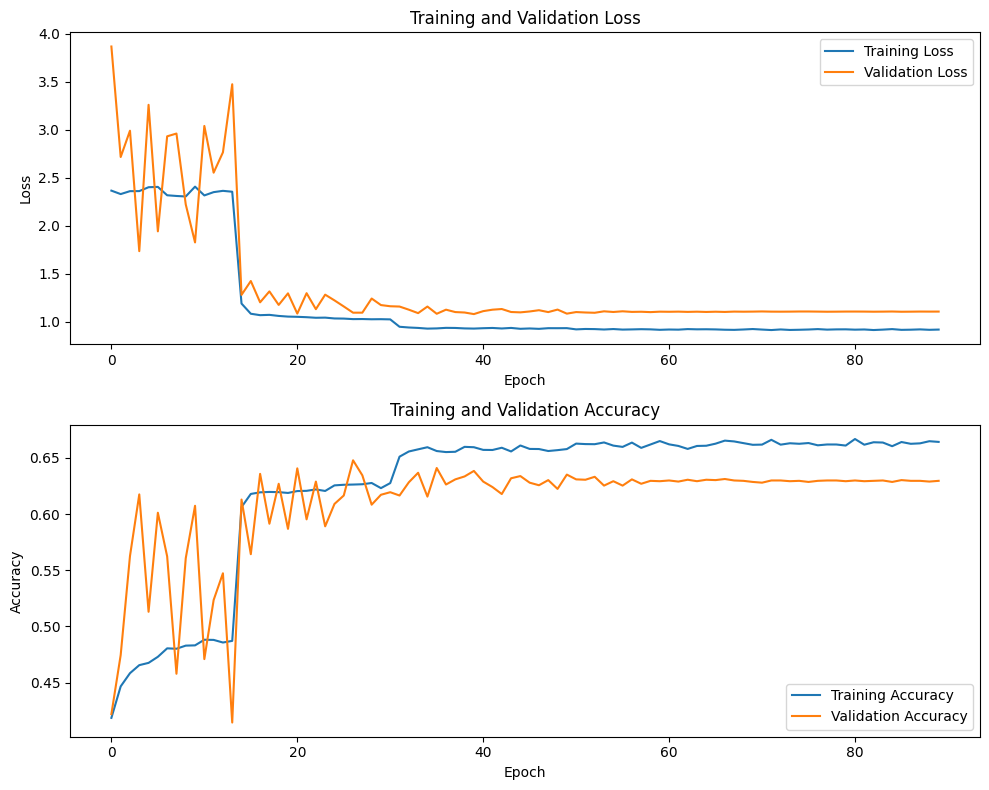

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training log from the CSV file
log_data = pd.read_csv(os.path.join(WORK_DIR, 'emotion_models/emotion_training.csv'))

# Get column names
columns = log_data.columns

# Plot both loss and accuracy in one figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot training loss and validation loss
if 'loss' in columns and 'val_loss' in columns:
    ax1.plot(log_data['loss'], label='Training Loss')
    ax1.plot(log_data['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

# Plot training accuracy and validation accuracy
if 'accuracy' in columns and 'val_accuracy' in columns:
    ax2.plot(log_data['accuracy'], label='Training Accuracy')
    ax2.plot(log_data['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

plt.tight_layout()
plt.show()


# Plot detail

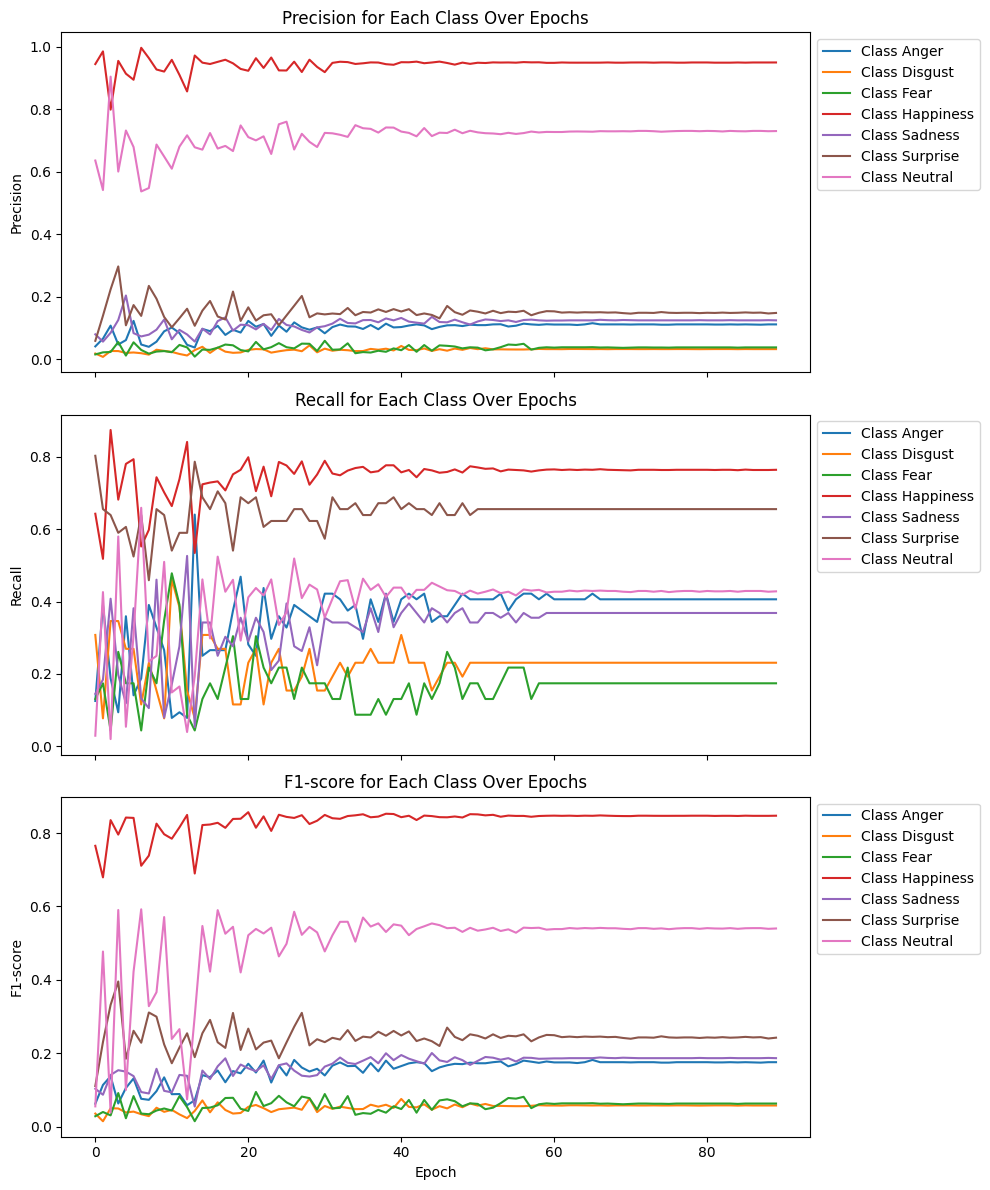

In [ ]:
import json
import matplotlib.pyplot as plt

# Read JSON data from a file
json_file_path = os.path.join(WORK_DIR, 'emotion_models/val_out_metrics.json')
with open(json_file_path, 'r') as json_file:
    json_data = json.load(json_file)

# Define the classes
classes = ['0', '1', '2', '3', '4', '5', '6']

# Define the metrics you want to plot (precision, recall, f1-score)
metrics = ['precision', 'recall', 'f1-score']

fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 12), sharex=True)

# Plot precision, recall, and F1-score for each class
for i, metric in enumerate(metrics):
    for class_label in classes:
        # Get the metric values for each epoch
        metric_values = [epoch[class_label][metric] for epoch in json_data]

        # Plot the metric values
        axs[i].plot(metric_values,
                    label=f'Class {CLASS_MAPPING[int(class_label)]}')

    axs[i].set_title(f'{metric.capitalize()} for Each Class Over Epochs')
    axs[i].set_ylabel(metric.capitalize())
    axs[i].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Set common x-axis label
axs[-1].set_xlabel('Epoch')

plt.tight_layout()
plt.show()


# Other

In [ ]:
import os

def count_files_in_directory(directory_path):
    try:
        # List all files in the directory
        files = os.listdir(directory_path)

        # Filter out directories and count the remaining files
        file_count = sum(1 for file in files if os.path.isfile(os.path.join(directory_path, file)))

        return file_count
    except FileNotFoundError:
        print(f"Directory not found: {directory_path}")
        return 0

# Example usage:
directory_path = FILES['data']
file_count = count_files_in_directory(directory_path)

print(f"Number of files in '{directory_path}': {file_count}")

Number of files in 'mnt/md0/projects/sami-hackathon/private/data': 15000
